# Modeling a Continuous Stirred-Tank Reactor (CSTR) for Biocatalysis

This notebook demonstrates a **well-mixed CSTR** with a **biocatalytic conversion** of substrate to product, including **competitive product inhibition** and **first-order enzyme deactivation**. We separate **kinetics** (via reactions) from **process physics** (flow/dilution + volume balance).

---

## System Overview

**Species**
- **S** — Substrate (fed continuously)
- **P** — Product (formed from S; competitively inhibits the reaction)
- **E** — Active enzyme (catalyst, subject to deactivation)
- **E_d** — Inactive enzyme pool (bookkeeping; can also be diluted out)
- **V** — Reactor volume

**Feeds & Flows**
- Inlet concentrations: $S_{\text{in}}, P_{\text{in}}, E_{\text{in}}$
- Volumetric flows: $F_{\text{in}}, F_{\text{out}}$
- Dilution rate: $D = \dfrac{F_{\text{in}}}{V}$ (for $F_{\text{in}}=F_{\text{out}}$ at steady $V$)

---

## Reaction Scheme & Rates

**Biocatalytic conversion with competitive inhibition**
\[
S \xrightarrow{\text{catalyzed by } E} P
\]

Rate (display):
$$
v_{\text{rxn}}(S,P,E) \;=\; \frac{k_{\text{cat}}\,E\,S}{K_m\!\left(1+\frac{P}{K_i}\right) + S}
$$

**Enzyme deactivation (first order)**

$$
v_{\text{deact}}(E) \;=\; k_{\text{deact}}\,E
$$

> **Units** (example): $S, P$ in mM; $E$ in g·L$^{-1}$ (or activity units); $k_{\text{cat}}$ in (mM·min$^{-1}$)/(g·L$^{-1}$); $K_m, K_i$ in mM; $k_{\text{deact}}$ in min$^{-1}$; $F$ in L·min$^{-1}$; $V$ in L.

---

## Dynamic Mass Balances (CSTR)

**Volume**
$$
\frac{dV}{dt} \;=\; F_{\text{in}} - F_{\text{out}}
$$

**Components** (dilution $+$ reaction; well-mixed):
$$
\frac{dS}{dt} \;=\; \frac{F_{\text{in}}}{V}\!\left(S_{\text{in}} - S\right)\;-\; v_{\text{rxn}}
$$
$$
\frac{dP}{dt} \;=\; \frac{F_{\text{in}}}{V}\!\left(P_{\text{in}} - P\right)\;+\; v_{\text{rxn}}
$$
$$
\frac{dE}{dt} \;=\; \frac{F_{\text{in}}}{V}\!\left(E_{\text{in}} - E\right)\;-\; v_{\text{deact}}
$$
$$
\frac{dE_d}{dt} \;=\; \frac{F_{\text{in}}}{V}\!\left(0 - E_d\right)\;+\; v_{\text{deact}}
$$

> The first term in each species balance is **dilution**: inflow at feed composition, outflow at reactor composition. The second term is the **net reaction** contribution.

---

## What You Should See

- With **no enzyme in the feed** ($E_{\text{in}}=0$), $E$ decays by **washout + deactivation** $\Rightarrow$ transient production followed by $S \to S_{\text{in}}$, $P \to P_{\text{in}}$.
- With **enzyme make-up** ($E_{\text{in}}>0$), the reactor reaches a non-zero steady-state $E^{*}$, sustaining conversion and a positive product steady state. Reducing $K_i$ makes inhibition visibly stronger.

---

## Mapping to the Code (Catalax)

- **Reactions** carry the *kinetics*: `add_reaction(..., equation="...")`
- **ODEs** add the *process physics*: volume balance and dilution terms.
- **Parameters/feeds** set kinetic constants and operating conditions.
- **Dataset** binds initial conditions and feed compositions for a given run.
- **SimulationConfig** controls solver horizon and resolution.

This separation keeps the kinetic model reusable across different unit operations (e.g., batch, fed-batch, CSTR) by swapping only the process ODE layer.

In [1]:
# Install Catalax (uncomment to install)
# %pip install catalax

In [2]:
import catalax as ctx

In [3]:
# Initialize the model
model = ctx.Model(
    name="CSTR biocatalysis: S → P with product inhibition + enzyme deactivation"
)

# Add states
model.add_states(
    S="Substrate",
    P="Product",
    E="Active enzyme",
    E_d="Inactive enzyme",
    V="Volume",
)

# Add feeds
model.add_constants(
    S_in="Substrate feed",
    P_in="Product feed",
    E_in="Enzyme feed",
)

In [4]:
# Biocatalytic conversion with competitive product inhibition
model.add_reaction(
    "S -> P",
    symbol="r_biocatalysis",
    equation="(k_cat * E * S) / (K_m * (1 + P / K_i) + S)",
)

# Enzyme deactivation (first-order)
model.add_reaction(
    "E ->  E_d",
    symbol="r_deact",
    equation="k_deact * E",
)

In [5]:
# We define the dilution rate as an assignment
model.add_assignment("D", "F_in / V")

# Define the process physics
model.add_odes(
    S="D * (S_in - S)",
    P="D * (P_in - P)",
    E="D * (E_in - E)",
    E_d="D * (0.0 - E_d)",
    V="F_in - F_out",
)

In [6]:
# Kinetic parameters
model.parameters["k_cat"].value = 5.0
model.parameters["K_m"].value = 50.0
model.parameters["K_i"].value = 100.0
model.parameters["k_deact"].value = 0.01

# Flow controls
model.parameters["F_in"].value = 0.2
model.parameters["F_out"].value = 0.2

In [7]:
# Create an empty dataset with ICs
dataset = ctx.Dataset.from_model(model)

# Reactor starts with substrate charge and active enzyme present; no product.
# Feed provides substrate only (here 50 mM), no product, no enzyme.
dataset.add_initial(
    S=50.0,
    P=0.0,
    E=0.5,
    E_d=0.0,
    V=10.0,
    S_in=50.0,
    P_in=0.0,
    E_in=0.0,
)

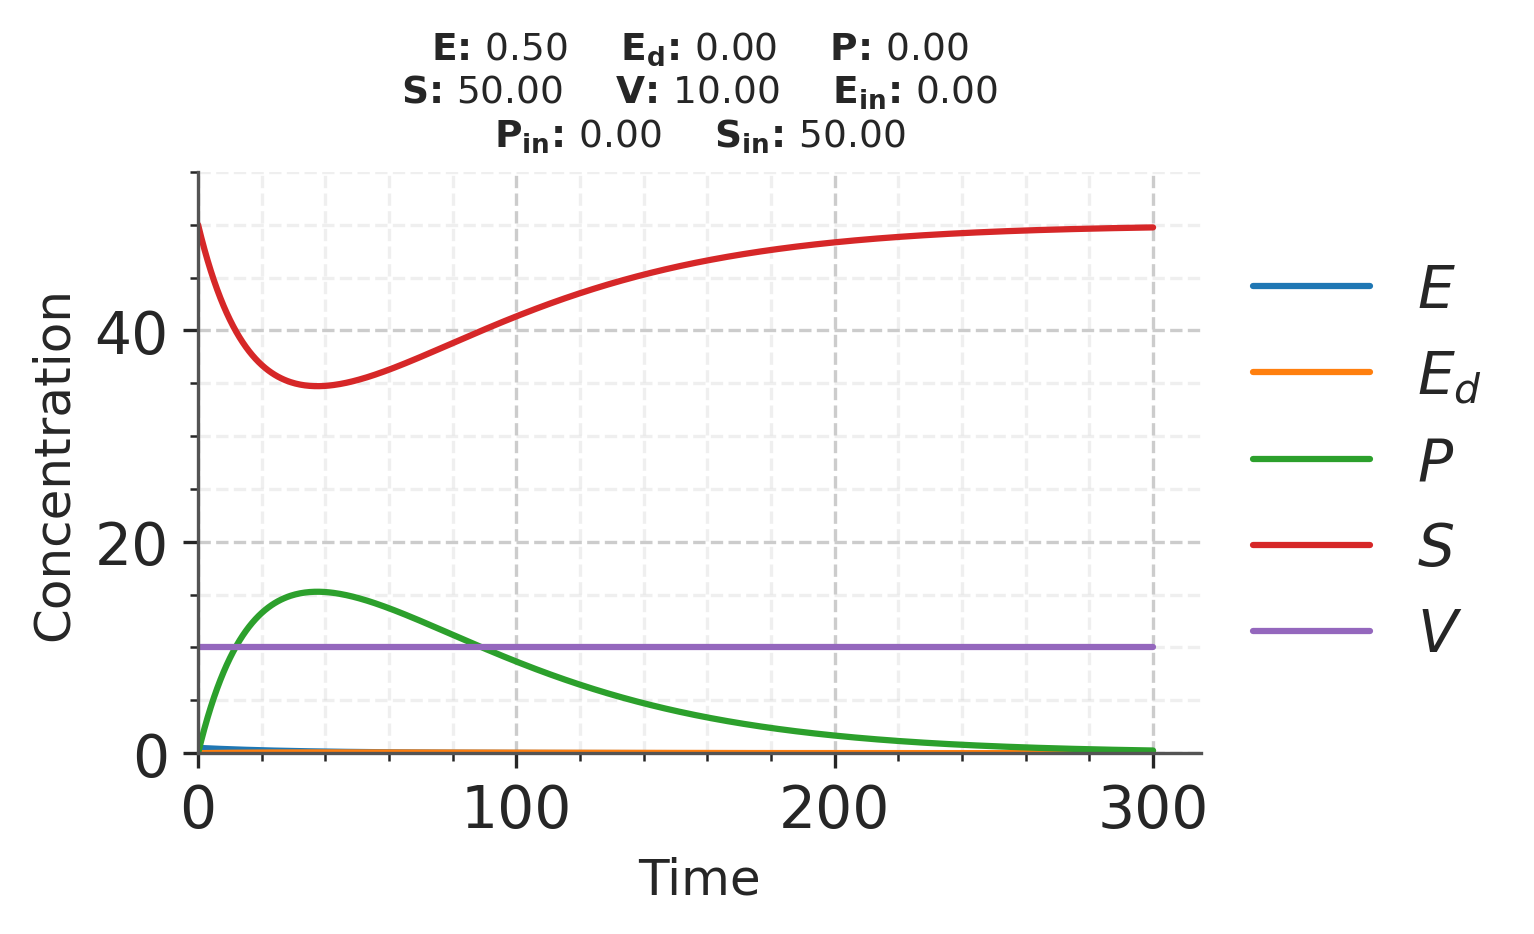

In [8]:
# Simulate the system
sim_cfg = ctx.SimulationConfig(t0=0, t1=300, nsteps=600)  # minutes
sim = model.simulate(dataset=dataset, config=sim_cfg)

# Plot (We'll use lines instead of markers)
sim.plot(show=True, linestyle="-", marker=None)